# Week 3 Jupyter Notebook - Linear Regression 3
For Week 3, include concepts such as linear regression with forward and backward selection, PCR, and PLSR. Complete your Jupyter Notebook homework by 11:59 pm ET on Sunday. 

## Load & Preprocess Data

# Peter Shmorhun Disclaimer:
My dataset is a classification Task. To fulfill the requirements for this paper I've created a dataset from portions of one of the 3 sources (The NFL Big Databowl 2023) - https://www.kaggle.com/competitions/nfl-big-data-bowl-2023

The new objective is to predict how many yards were gained on a dataset of about 9k plays:

Here is the a little map of what's in the dataset

| column | verdict| checklist |
| :--- | :--- | :--- |
| gameId | drop | |
| playId | drop | |
| playDescription | drop | x |
| quarter | one-hot | x |
| down | one-hot, drop down = 0 plays | x |
| yardsToGo | keep, no transform | x |
| possessionTeam | one-hot | x |
| defensiveTeam | one-hot | x |
| yardlineSide | drop | x |
| yardlineNumber | keep | x |
| gameClock | keep, possibly transform to "seconds remaining" | x |
| preSnapHomeScore | keep, good for game context | x |
| passResult | one-hot after cleaning | x |
| penaltyYards | replace nulls with 0, use as is | x |
| prePenaltyPlayResult | keep as is | x |
| playResult | target | | 
| 'foulName1' | drop | x | 
| 'foulNFLId1| drop | x |
| 'foulName2' | drop | x |
| foulNFLId2 | drop | x | 
| foulName3 | drop | x |
| foulNFLId3 | drop | x| 
| absoluteYardlineNumber | keep | x |
| offenseFormation | One-Hot encode |
| personnelO | parse columns, use RE to aggreagate into columns of personnel counts (#rb, #wr, etc.) | x |
| dropBackType | One-hot encode | x |
| defendersInBox | keep | x |
| personnelD | same as personnelO | x |
| pff_playAction' | keep | x | 
| pff_passCoverage | one-hot | x |
| pff_passCoverageType | one-hot | x |
| pff_cole | aggregate by OL count of by pff_role category | x |  
| 'pff_positionLinedUp' | drop | x |
| pff_hit | keep | x |
| pff_hurry | keep | x |
| pff_sack | keep | x |
| pff_beatenByDefender | keep | x |
| pff_hitAllowed | keep | x |
| pff_sackAllowed | keep | x | 
| pff_nflIdBlockedPlayer | drop | x|
| pff_blockType | drop | x| 
| pff_backFieldBlock | Keep | x |


passResult - (C: Complete pass, I: Incomplete pass, S: Quarterback sack, IN: Intercepted pass, R: Scramble)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import re
import io
import zipfile
import time
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

# Define the folder path
folder_path = '/home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/nfl-big-data-bowl-2023.zip'
extract_path = '/home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/nfl-big-data-bowl-2023'

# Check if the extraction directory already exists
if not os.path.exists(extract_path):
    # Unzip the file
    with zipfile.ZipFile(folder_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted all files to {extract_path}")
else:
    print(f"Directory {extract_path} already exists, skipping extraction.")

# List all CSV files in the folder
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]

# Initialize an empty dictionary to store dataframes
dataframes = {}

# Load each CSV file as a separate dataframe with a progress bar
for file in tqdm(csv_files, desc="Loading CSV files", unit="file"):
    file_path = os.path.join(extract_path, file)
    df_name = os.path.splitext(file)[0]
    dataframes[df_name] = pd.read_csv(file_path)

# Convert dictionary to global variables
for key, df in dataframes.items():
    globals()[key] = df


Directory /home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/nfl-big-data-bowl-2023 already exists, skipping extraction.


Loading CSV files: 100%|██████████| 13/13 [00:03<00:00,  3.69file/s]


### Create Dataset

In [2]:
# 1. Copy your plays DataFrame
plays_processed = plays.copy()

# 2. Drop unwanted columns (including any that start with "foul")
foul_cols = [col for col in plays_processed.columns if col.startswith('foul')]
plays_processed = plays_processed.drop(
    columns=['playDescription', 'yardlineSide'] + foul_cols
)

# 3. Remove placeholder plays (down == 0)
plays_processed = plays_processed[plays_processed['down'] != 0]

# 4. Convert gameClock to seconds & fill penaltyYards in one go
def convert_game_clock(clock_str):
    if pd.isna(clock_str):
        return np.nan
    mins, secs = map(int, clock_str.split(":"))
    return mins * 60 + secs

# convert from time stamp to seconds
plays_processed['gameClock'] = plays_processed['gameClock'].apply(convert_game_clock)

# 5. Generic function to extract personnel counts
def extract_personnel_counts(df, col, positions, suffix):
    """
    From df[['gameId','playId',col]], extract counts of each position
    and return a DataFrame with columns <pos>_<suffix>.
    """
    temp = (
        df[['gameId','playId',col]]
        .fillna('UNKNOWN')
        .set_index(['gameId','playId'])
    )
    extracted = (
        temp[col]
        .str.extractall(r'(?P<num>\d+)\s+(?P<pos>[A-Z]+)')
        .reset_index()
        .query('pos in @positions')
        .assign(num=lambda x: x['num'].astype(int))
        .groupby(['gameId','playId','pos'])['num']
        .sum()
        .unstack(fill_value=0)
    )
    # ensure every position appears
    for pos in positions:
        if pos not in extracted.columns:
            extracted[pos] = 0
    extracted = extracted[positions]
    extracted = extracted.add_suffix(f'_{suffix}').reset_index()
    return extracted

# 6. Parse offense personnel
positions_off = ['RB','TE','WR','OL','QB','LB']
offense_counts = extract_personnel_counts(
    plays_processed, 'personnelO', positions_off, 'offensecount'
)
plays_processed = plays_processed.merge(
    offense_counts, on=['gameId','playId'], how='left'
)

# 7. Parse defense personnel
positions_def = ['DB','DL','LB']
defense_counts = extract_personnel_counts(
    plays_processed, 'personnelD', positions_def, 'defensecount'
)
plays_processed = plays_processed.merge(
    defense_counts, on=['gameId','playId'], how='left'
)

# 8. Drop original personnel columns
plays_processed = plays_processed.drop(columns=['personnelO','personnelD'])

# 9. Aggregate offensive line stats
ol_agg = (
    pffScoutingData
    .drop(columns=['pff_positionLinedUp','pff_nflIdBlockedPlayer','pff_blockType'])
    .groupby(['gameId','playId'])
    .agg({
        'pff_hit':'sum','pff_hurry':'sum','pff_sack':'sum',
        'pff_beatenByDefender':'sum','pff_hitAllowed':'sum',
        'pff_hurryAllowed':'sum','pff_sackAllowed':'sum',
        'pff_backFieldBlock':'sum'
    })
    .reset_index()
)
plays_processed = plays_processed.merge(
    ol_agg, on=['gameId','playId'], how='left'
)

# 10. Fill any missing OL stats with 0
ol_cols = [
    'pff_hit','pff_hurry','pff_sack','pff_beatenByDefender',
    'pff_hitAllowed','pff_hurryAllowed','pff_sackAllowed','pff_backFieldBlock'
]
plays_processed[ol_cols] = plays_processed[ol_cols].fillna(0).astype(int)

# 11. One-hot encode categoricals
one_hot_columns = [
    'quarter','down','possessionTeam','defensiveTeam',
    'passResult','offenseFormation','dropBackType',
    'pff_passCoverage','pff_passCoverageType'
]
# set drop_first=True if you want to avoid the dummy-trap
encoded = pd.get_dummies(
    plays_processed[one_hot_columns],
    drop_first=True,
    dtype=int
)
plays_processed = pd.concat(
    [plays_processed.drop(columns=one_hot_columns), encoded],
    axis=1
)

# 12. Final DataFrame ready for modeling
plays_processed = plays_processed.drop(columns=['gameId', 'playId'])
df_final = plays_processed.copy()
# Fill NaN values with 0
df_final = df_final.fillna(0)
df_final.head()

,yardsToGo,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,penaltyYards,prePenaltyPlayResult,playResult,absoluteYardlineNumber,defendersInBox,...,pff_passCoverage_Cover-2,pff_passCoverage_Cover-3,pff_passCoverage_Cover-6,pff_passCoverage_Goal Line,pff_passCoverage_Miscellaneous,pff_passCoverage_Prevent,pff_passCoverage_Quarters,pff_passCoverage_Red Zone,pff_passCoverageType_Other,pff_passCoverageType_Zone
0,2,33,813,0,0,0.0,0,0,43.0,6.0,...,0,0,0,0,0,0,0,0,0,0
1,10,2,798,0,0,0.0,28,28,108.0,6.0,...,0,1,0,0,0,0,0,0,0,1
2,6,34,743,0,0,0.0,5,5,76.0,6.0,...,0,1,0,0,0,0,0,0,0,1
3,10,39,596,0,0,0.0,0,0,49.0,6.0,...,0,1,0,0,0,0,0,0,0,1
4,15,44,586,0,0,0.0,0,0,54.0,7.0,...,0,1,0,0,0,0,0,0,0,1


In [12]:
import numpy as np

# Calculate IQR of playResult
Q1 = df_final['playResult'].quantile(0.25)
Q3 = df_final['playResult'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out extreme outliers
df_no_outliers = df_final[(df_final['playResult'] >= lower_bound) & (df_final['playResult'] <= upper_bound)].copy()

# Print info about the filtering
print(f"Original dataset size: {len(df_final)}")
print(f"After removing outliers: {len(df_no_outliers)}")
print(f"Removed {len(df_final) - len(df_no_outliers)} outliers")
print(f"IQR bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Prepare data for modeling
y_no_outliers = df_no_outliers['playResult']
X_no_outliers = df_no_outliers.drop(columns=['playResult'])


Original dataset size: 8522
After removing outliers: 8149
Removed 373 outliers
IQR bounds: [-16.50, 27.50]


In [14]:
from sklearn.model_selection import train_test_split

# 1) Split into train/test
X = X_no_outliers.drop(columns=['prePenaltyPlayResult', 'penaltyYards'])
y = y_no_outliers

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

## Linear Regression With Forward and Backward Selection

### Forward Selection

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector,f_regression,SelectKBest
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from itertools import chain, combinations

In [17]:
# Forward Feature Selection

def forward_feature_selection(X, y, model, 
                                      scoring='neg_mean_squared_error', 
                                      cv=5, 
                                      tol=None,               # None = no delta cutoff
                                                              # use 0.0 for "no further improvements"
                                                              # and 1e-4 for "point of diminishing returns"                                      
                                      max_features=None,      # None = use all features
                                      n_jobs = -1,
                                      verbose = True
                                     ):
    selected_features = []
    remaining_features = list(X.columns)
    best_scores = []
    previous_score = float('inf')
    
    # Model to use for evaluation
    model = LinearRegression()

    # Track the best subset and its score
    best_forward_features = None
    best_score = float('inf')
    
    while remaining_features:
        scores = {}
        for feature in remaining_features:
            current_features = selected_features + [feature]
            # Compute the CV score
            cv_score = -cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv,n_jobs=n_jobs,
                                       ).mean()
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]

        # Check if the improvement is significant
        if verbose and tol is not None and previous_score - current_score < tol:
            print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"Features: {selected_features}, CV Score (MSE): {current_score:.4f}")
        
        # Update the best subset if the current score is the best so far
        if current_score < best_score:
            best_score = current_score
            best_forward_features = selected_features.copy()
        
        # Check if max_features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return selected_features, best_scores, best_forward_features, best_score

Features: ['passResult_I'], CV Score (MSE): 49.6373
Features: ['passResult_I', 'passResult_S'], CV Score (MSE): 35.9039
Features: ['passResult_I', 'passResult_S', 'passResult_IN'], CV Score (MSE): 33.9572
Features: ['passResult_I', 'passResult_S', 'passResult_IN', 'passResult_R'], CV Score (MSE): 33.5433
Features: ['passResult_I', 'passResult_S', 'passResult_IN', 'passResult_R', 'pff_passCoverage_Red Zone'], CV Score (MSE): 33.3341
Features: ['passResult_I', 'passResult_S', 'passResult_IN', 'passResult_R', 'pff_passCoverage_Red Zone', 'dropBackType_SCRAMBLE'], CV Score (MSE): 33.2021
Features: ['passResult_I', 'passResult_S', 'passResult_IN', 'passResult_R', 'pff_passCoverage_Red Zone', 'dropBackType_SCRAMBLE', 'pff_hurry'], CV Score (MSE): 33.0567
Features: ['passResult_I', 'passResult_S', 'passResult_IN', 'passResult_R', 'pff_passCoverage_Red Zone', 'dropBackType_SCRAMBLE', 'pff_hurry', 'pff_playAction'], CV Score (MSE): 32.9529
Features: ['passResult_I', 'passResult_S', 'passResult_

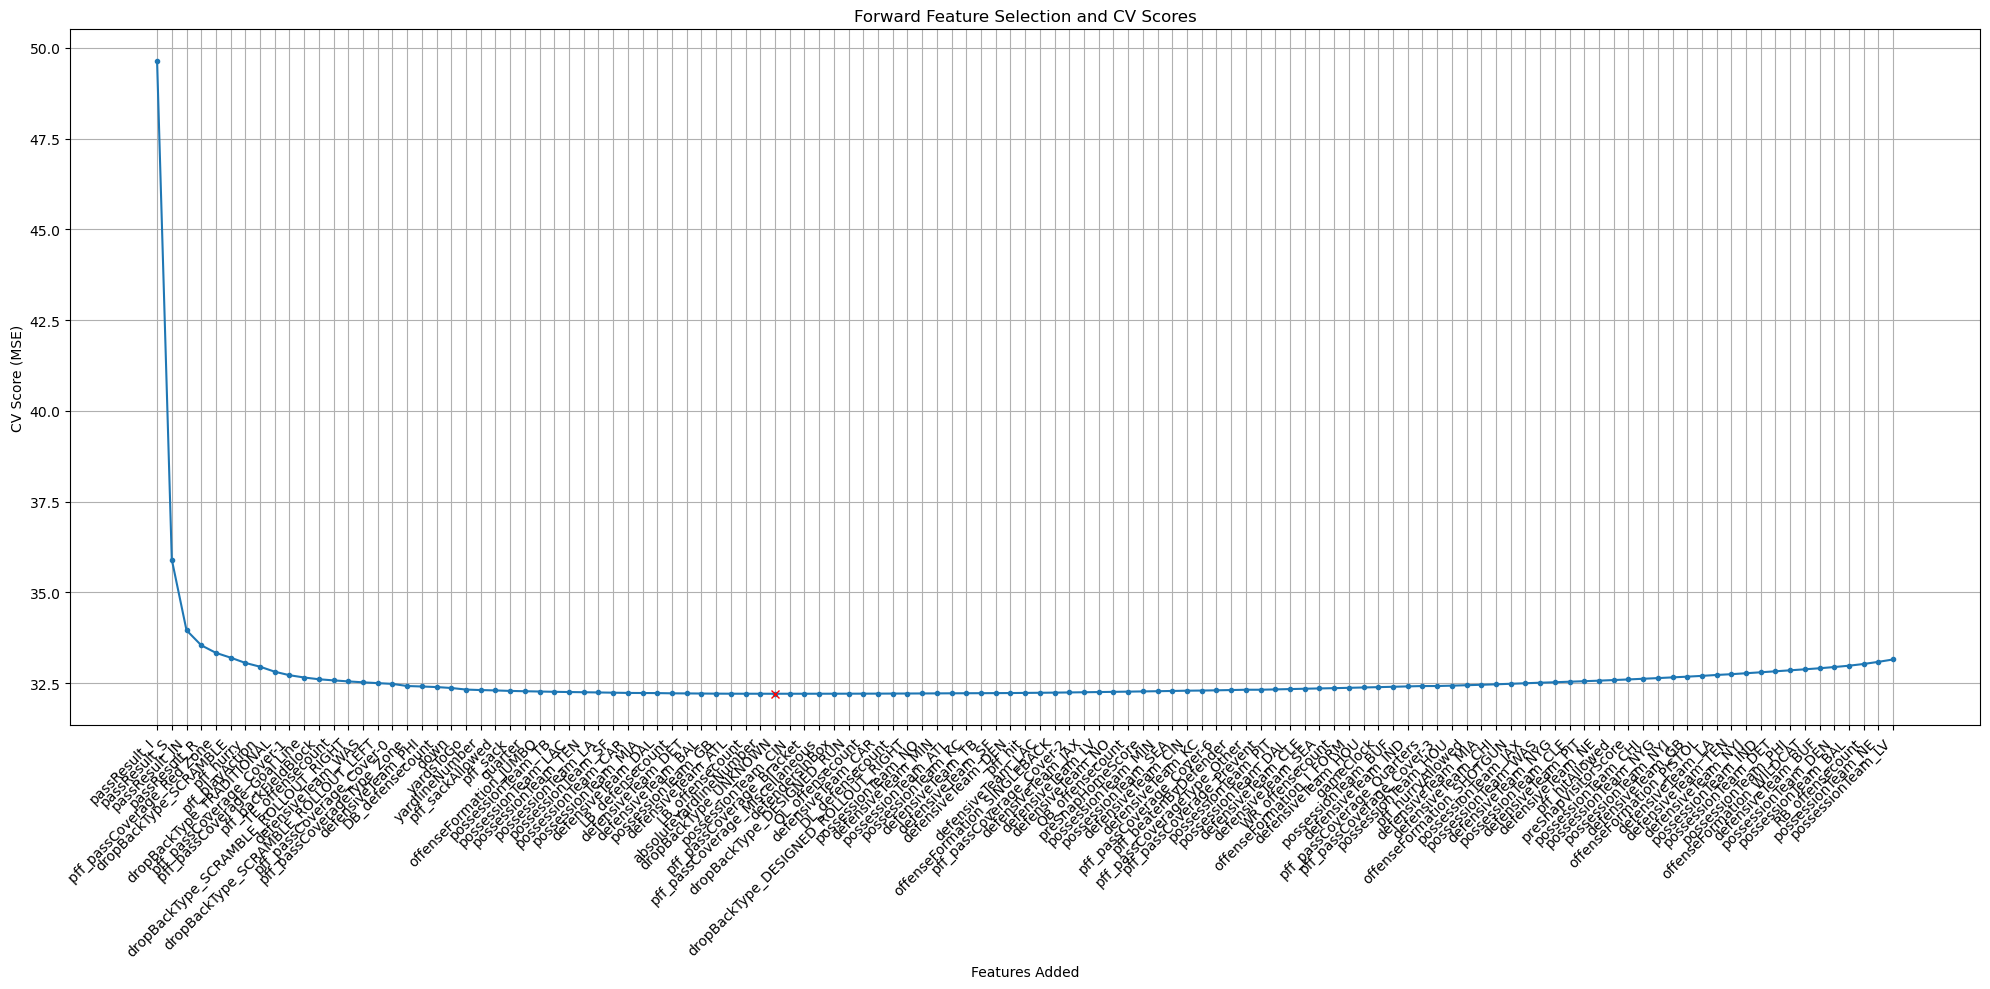

Best Features: ['passResult_I', 'passResult_S', 'passResult_IN', 'passResult_R', 'pff_passCoverage_Red Zone', 'dropBackType_SCRAMBLE', 'pff_hurry', 'pff_playAction', 'dropBackType_TRADITIONAL', 'pff_passCoverage_Cover-1', 'pff_passCoverage_Goal Line', 'pff_backFieldBlock', 'TE_offensecount', 'dropBackType_SCRAMBLE_ROLLOUT_RIGHT', 'defensiveTeam_WAS', 'dropBackType_SCRAMBLE_ROLLOUT_LEFT', 'pff_passCoverage_Cover-0', 'pff_passCoverageType_Zone', 'defensiveTeam_PHI', 'DB_defensecount', 'down', 'yardsToGo', 'yardlineNumber', 'pff_sackAllowed', 'pff_sack', 'quarter', 'offenseFormation_JUMBO', 'possessionTeam_TB', 'possessionTeam_LAC', 'possessionTeam_TEN', 'possessionTeam_LA', 'possessionTeam_SF', 'possessionTeam_CAR', 'possessionTeam_MIA', 'defensiveTeam_DAL', 'LB_defensecount', 'defensiveTeam_DET', 'defensiveTeam_BAL', 'possessionTeam_GB', 'defensiveTeam_ATL', 'LB_offensecount', 'absoluteYardlineNumber', 'dropBackType_UNKNOWN']
Best CV Score: 32.2081
Test MSE: 34.3355


In [19]:
# Run Forward Feature Selection
model = LinearRegression()
selected_features, best_scores, best_forward_features, best_score = (forward_feature_selection(X, y, model, verbose=True) )

# Plot the results
index = np.argmax(np.array(selected_features) == best_forward_features[-1])

plt.figure(figsize=(20, 10))
plt.plot(range(1, len(best_scores) + 1), best_scores, marker='.')
plt.plot([index+1],best_score,marker='x',color='red')
plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=45, ha='right')
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (MSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print the best subset and score
print(f"Best Features: {best_forward_features}")
print(f"Best CV Score: {best_score:.4f}")

# Filter X_train and X_test to include only the selected features
X_train_best = X_train[best_forward_features]
X_test_best = X_test[best_forward_features]

# Run the test set through the model
model = LinearRegression()
model.fit(X_train_best, y_train)

y_pred = model.predict(X_test_best)

test_mse = mean_squared_error(y_test, y_pred)

print(f"Test MSE: {test_mse:.4f}")

### Takeaways
- passresult dummy variables produce the largest model performance gain. ust the four `passResult_` dummies slashed MSE from ~50  to ~35.
- medium improvement from the next 3–4: yardline, play‐action, scramble and one coverage var each chipped off 0.3–0.5 MSE.
- after ~10–15 features: each extra predictor only shaves off ~0.1–0.2 MSE.
-  beyond ~52 features the CV MSE actually ticks back up. 
- `passResult_*` flags, yardline, play‐action and a handful of coverage/dropback signals explain most of the variance.
- ~99% of the CV gain with 10–15 features.


### Backward Selection

In [20]:
# Backward Feature Selection

def backward_feature_selection(X, y, model, 
                               scoring='neg_mean_squared_error', 
                               cv=5, 
                               tol=None,               # None = no delta cutoff
                                                       # use 0.0 for "no further improvements"
                                                       # and 1e-4 for "point of diminishing returns"                                      
                               max_features=None,      # If None, remove features until only 1 remains
                                                       # Otherwise, stop when this many features remain
                               n_jobs=-1,
                               verbose=True
                              ):
    
    # Helper function to compute CV score using LinearRegression
    def cv_score(features):
        return -cross_val_score(model, X[features], y, 
                                scoring=scoring, cv=cv, 
                                n_jobs=n_jobs          ).mean()
    
    # Start with all features (using a list for easier manipulation)
    features_remaining = list(X.columns)
    
    # Compute initial CV score with the full feature set
    initial_score = cv_score(features_remaining)
    
    # Initialize tracking variables
    best_score        = initial_score                # Best (lowest) CV score observed so far
    best_feature_set  = features_remaining.copy()    # Feature set corresponding to best_score
    selected_features = ['NONE']                     # List to record the order in which features are removed
    best_scores       = [initial_score]              # List to record the CV score after each removal (starting with full set)
    
    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV score (MSE): {np.around(initial_score, 4)}\n')
    
    # Determine the target number of features to keep:
    # For backward elimination, if max_features is None, we remove until 1 feature remains.
    target_feature_count = 1 if max_features is None else max_features
    
    prev_score = initial_score
    round_num = 1
    # Continue removing features until we reach the target count
    while len(features_remaining) > target_feature_count:
        if verbose:
            print(f'Round {round_num}:')
            
        # Initialize variables to track the best removal in this round
        lowest_score = float('inf')
        feature_to_remove = None
        best_new_features = None
        
        # Try removing each feature one at a time
        for feature in features_remaining:
            new_feature_set = features_remaining.copy()
            new_feature_set.remove(feature)
            new_score = cv_score(new_feature_set)
            if verbose:
                print('Trying removal of:',feature, np.around(new_score, 4))
            if new_score < lowest_score:
                lowest_score = new_score
                feature_to_remove = feature
                best_new_features = new_feature_set
        
        # Check if improvement is significant enough (if tol is set)
        if tol is not None and (prev_score - lowest_score) < tol:
            if verbose:
                print("\nStopping early due to minimal improvement.")
            break
        
        # Update the best score and feature set if current removal improves performance
        if lowest_score < best_score:
            best_score = lowest_score
            best_feature_set = best_new_features.copy()
        
        # Update trackers for this round
        prev_score = lowest_score
        features_remaining = best_new_features
        selected_features.append(feature_to_remove)
        best_scores.append(lowest_score)
        
        if verbose:
            print(f'\nRemoving {feature_to_remove}:  CV score (MSE) {np.around(lowest_score, 4)}\n')
        round_num += 1

    return (
        selected_features,      # Order in which features were removed
        best_scores,            # CV scores after each removal step
        best_feature_set,       # Feature set that achieved the best CV score
        best_score              # Best (lowest) CV score
    )


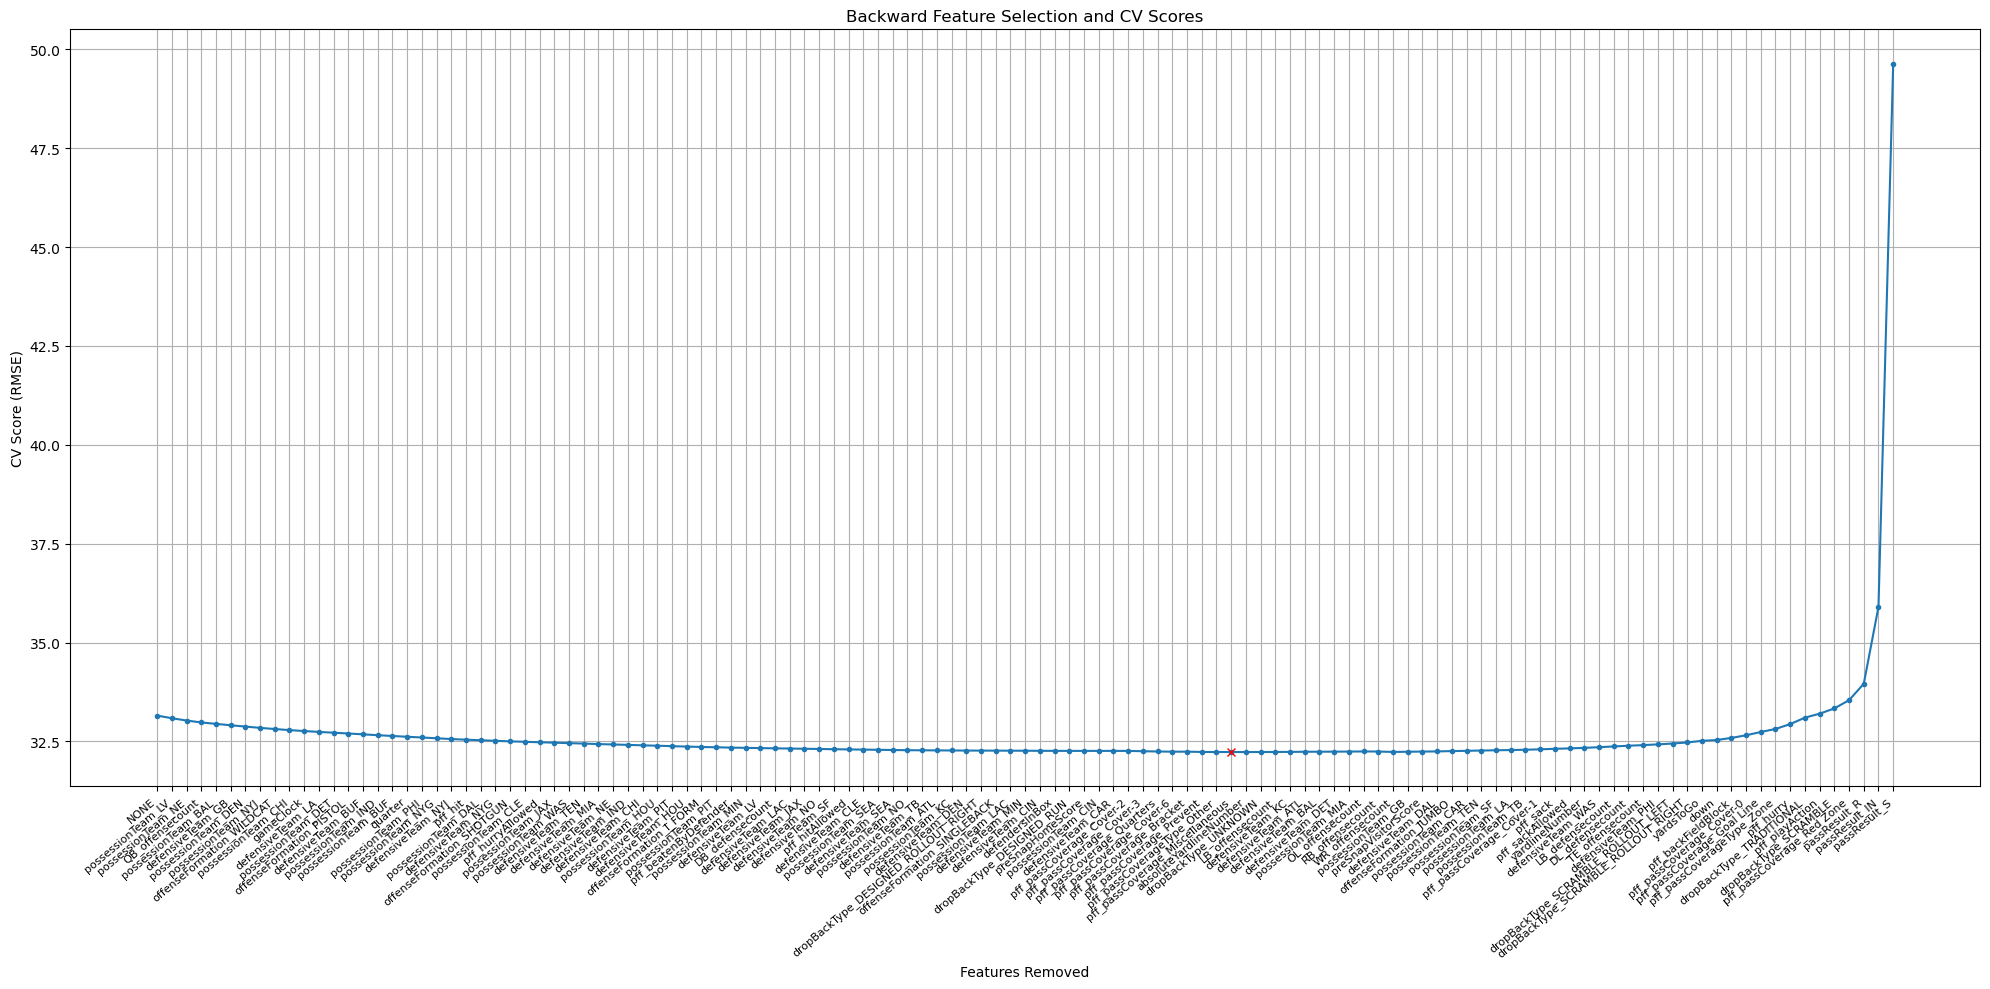

Best feature set: ['yardsToGo', 'yardlineNumber', 'preSnapVisitorScore', 'absoluteYardlineNumber', 'pff_playAction', 'RB_offensecount', 'TE_offensecount', 'WR_offensecount', 'OL_offensecount', 'LB_offensecount', 'DL_defensecount', 'LB_defensecount', 'pff_hurry', 'pff_sack', 'pff_sackAllowed', 'pff_backFieldBlock', 'down', 'possessionTeam_CAR', 'possessionTeam_GB', 'possessionTeam_LA', 'possessionTeam_MIA', 'possessionTeam_SF', 'possessionTeam_TB', 'possessionTeam_TEN', 'defensiveTeam_ATL', 'defensiveTeam_BAL', 'defensiveTeam_DAL', 'defensiveTeam_DET', 'defensiveTeam_KC', 'defensiveTeam_PHI', 'defensiveTeam_WAS', 'passResult_I', 'passResult_IN', 'passResult_R', 'passResult_S', 'offenseFormation_JUMBO', 'dropBackType_SCRAMBLE', 'dropBackType_SCRAMBLE_ROLLOUT_LEFT', 'dropBackType_SCRAMBLE_ROLLOUT_RIGHT', 'dropBackType_TRADITIONAL', 'dropBackType_UNKNOWN', 'pff_passCoverage_Cover-0', 'pff_passCoverage_Cover-1', 'pff_passCoverage_Goal Line', 'pff_passCoverage_Red Zone', 'pff_passCoverageTyp

In [21]:
# run backward selection and display results

model = LinearRegression()

selected_features, best_scores, best_feature_set, best_score = (
    backward_feature_selection(X, y, model, verbose=False)                             
)

plt.figure(figsize=(20, 10))
plt.title('Backward Feature Selection and CV Scores')
plt.plot(range(1, len(best_scores) + 1), best_scores, marker='.')
index = np.argmin(best_scores) 
plt.plot([index + 1], best_scores[index], marker='x', color='red')  
plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=40, ha='right', fontsize=8)
plt.xlabel('Features Removed')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print minimum cv score

print("Best feature set:", best_feature_set)
print("CV score (MSE):",np.around(best_score,4))


# Test

# Filter X_train and X_test to include only the selected features
X_train_best_backward = X_train[best_feature_set]
X_test_best_backward = X_test[best_feature_set]

# Train the LinearRegression model on the selected features
model = LinearRegression()
model.fit(X_train_best_backward, y_train)

# Predict on the test set
y_pred = model.predict(X_test_best_backward)

# Calculate the test MSE
test_mse = mean_squared_error(y_test, y_pred)

print(f"Test MSE: {test_mse:.4f}")

Forward/Backward Selection Analysis:
1. Common “core” predictors:
- **Pass-result dummies** (`passResult_I`, `passResult_S`, `passResult_IN`, `passResult_R`)
- **Yard line** (`yardlineNumber`)
- **Play action** (`pff_playAction`)
- **Drop-back types** (`dropBackType_SCRAMBLE`, `dropBackType_DESIGNED_ROLLOUT_RIGHT`)
- **Back-field block** (`pff_backFieldBlock`)
- **Red-zone coverage** (`pff_passCoverage_Red Zone` or its encoded equivalents)

2. Forward selection
- Stops at 22 features, right where adding more gives diminishing returns.
- You end up with a compact model that hits the lowest CV MSE (≈ 35).
- On held-out test the model performs about the same, suggesting good generalization. 
- After the core eight or so, it tacks on a few coverage‐type flags and the two most informative team indicators (`MIA`, `LA`).

3. Backward selection
-  Starts with everything and peels off the least-useful one by one.
- Hits its sweet spot when it has removed about half the features— leaving 51 still in the model.
- CV performance bottoms out at an almost identical level (∼ 35 MSE), but test error creeps up slightly.
- Because it keeps in things like `yardsToGo`, `preSnapVisitorScore`, `defendersInBox`, `hurry/sack metrics`, a whole slew of team dummies, and an assortment of coverage‐type flags, you end up with a `much larger` feature set for almost no gain.

4. Takeaways:
- Top signals are the same in both: pass­result, yardline, play action, drop-back type, back-field block, and a handful of coverage flags.
- Backward selection overfits a bit—it hogs dozens more features (many low-signal team indicators and nuance flags) without driving down error.


## PCR/PLSR

In [22]:
# set up principal component regression 
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
random_state = 42

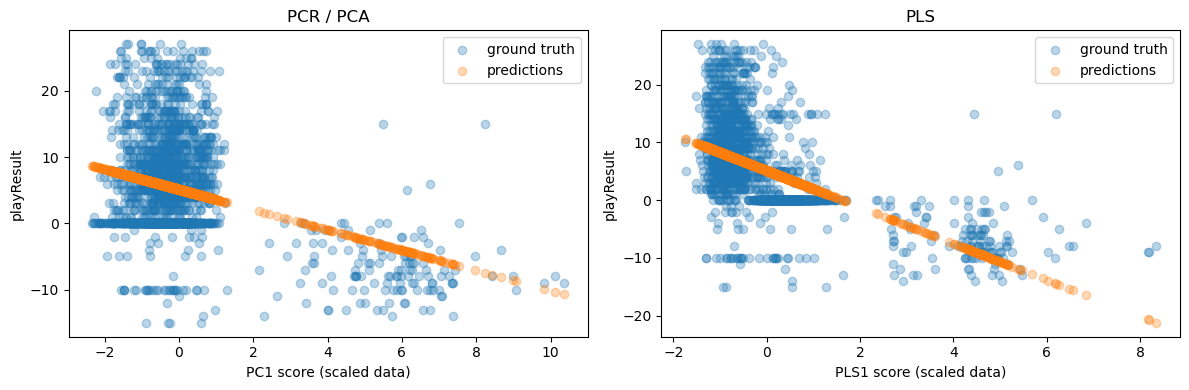

PCR R²: 0.118
PLS R²: 0.331


In [25]:
best_features = ['passResult_I', 'passResult_S', 'passResult_IN', 'passResult_R', 'yardlineNumber', 'pff_playAction', 'dropBackType_SCRAMBLE', 'pff_passCoverage_Cover-1', 'dropBackType_DESIGNED_ROLLOUT_RIGHT', 'pff_backFieldBlock', 'pff_passCoverage_Red Zone', 'possessionTeam_MIA', 'pff_passCoverageType_Zone', 'pff_passCoverage_Goal Line', 'pff_passCoverage_Cover-0', 'possessionTeam_LA', 'pff_hurry', 'down', 'defensiveTeam_NYG', 'defensiveTeam_PHI', 'possessionTeam_DET', 'defensiveTeam_DET', 'pff_passCoverage_Quarters', 'yardsToGo', 'quarter', 'possessionTeam_SF', 'possessionTeam_LV', 'DL_defensecount', 'possessionTeam_SEA', 'possessionTeam_CIN', 'defensiveTeam_HOU', 'possessionTeam_IND', 'pff_passCoverage_Cover-2', 'possessionTeam_TB', 'possessionTeam_BAL', 'defendersInBox', 'TE_offensecount', 'defensiveTeam_CIN', 'possessionTeam_GB', 'defensiveTeam_BUF', 'defensiveTeam_BAL', 'pff_passCoverage_Miscellaneous', 'possessionTeam_CAR', 'offenseFormation_PISTOL', 'offenseFormation_SHOTGUN', 'possessionTeam_NE', 'possessionTeam_MIN', 'defensiveTeam_IND', 'pff_sack', 'pff_sackAllowed', 'defensiveTeam_NO', 'defensiveTeam_LA']

# features & target
X = df_no_outliers[best_features]
y = df_no_outliers['playResult'].astype(int)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

# PCR pipeline
pcr_pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=1),
    LinearRegression()
)
pcr_pipe.fit(X_train, y_train)

# extract the first PC scores on the properly scaled test set
X_test_scaled = pcr_pipe.named_steps['standardscaler'].transform(X_test)
pc1_scores    = pcr_pipe.named_steps['pca'].transform(X_test_scaled)

# PLS pipeline
pls_pipe = make_pipeline(
    StandardScaler(),
    PLSRegression(n_components=1, scale=False)  # scale=False since we scaled above
)
pls_pipe.fit(X_train, y_train)

# extract the first PLS scores on the same scaled test set
pls_scores = pls_pipe.named_steps['plsregression'].transform(X_test_scaled)

# plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# PCR plot
axes[0].scatter(pc1_scores, y_test,         alpha=0.3, label="ground truth")
axes[0].scatter(pc1_scores, pcr_pipe.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(
    xlabel="PC1 score (scaled data)",
    ylabel="playResult",
    title="PCR / PCA"
)
axes[0].legend()

# PLS plot
axes[1].scatter(pls_scores, y_test,         alpha=0.3, label="ground truth")
axes[1].scatter(pls_scores, pls_pipe.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(
    xlabel="PLS1 score (scaled data)",
    ylabel="playResult",
    title="PLS"
)
axes[1].legend()

plt.tight_layout()
plt.show()

# R^2 on test set
print(f"PCR R²: {pcr_pipe.score(X_test, y_test):.3f}")
print(f"PLS R²: {pls_pipe.score(X_test, y_test):.3f}")



PCR (1 PC) is doing essentially unsupervised dimensionality reduction, so its first component has very little alignment with the target—hence the low $R^2 \approx 0.118$

PLS (1 component) explicitly finds the direction in $X$  that maximizes covariance with $y$ so it gets a much higher $R^2 \approx 0.331$

Next, let's see if adjusting the number of principal components helps using `gridsearchCV`

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# PCR grid
pcr_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('pca',   PCA()),
    ('reg',   Ridge())
])
pcr_params = {
    'pca__n_components': [1, 2, 5, 10, 20],
    'reg__alpha':        [0.1, 1, 10],
}

pcr_gs = GridSearchCV(pcr_pipe, pcr_params, cv=5, scoring='r2')
pcr_gs.fit(X, y)
print("Best PCR:", pcr_gs.best_params_, "R²:", pcr_gs.best_score_)

# PLS grid
pls_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('pls',   PLSRegression())
])
pls_params = {
    'pls__n_components': [1, 2, 5, 10],
}
pls_gs = GridSearchCV(pls_pipe, pls_params, cv=5, scoring='r2')
pls_gs.fit(X, y)
print("Best PLS:", pls_gs.best_params_, "R²:", pls_gs.best_score_)


Best PCR: {'pca__n_components': 20, 'reg__alpha': 10} R²: 0.20413330319394615
Best PLS: {'pls__n_components': 10} R²: 0.4563848646113394


Optimal PCR uses 20 principal components with a Ridge penalty of $\alpha = 10$, giving a cross-validated $R^2 \approx 0.204$

Optimal PLS finds that 10 PLS components yield $R^2 \approx 0.457$

That confirms what we saw before: even with more components, PCR lags behind PLS, because PCR’s components aren’t informed by the target.

Let's evaulate on the test set using those best models:

In [27]:
# split once up front
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# grab best estimators from grid-search
pcr_final = pcr_gs.best_estimator_
pls_final = pls_gs.best_estimator_

# fit on full training fold
pcr_final.fit(X_train, y_train)
pls_final.fit(X_train, y_train)

# test performance
print("PCR test  R²:", pcr_final.score(X_test, y_test))
print("PLS test  R²:", pls_final.score(X_test, y_test))

PCR test  R²: 0.20677273034621457
PLS test  R²: 0.45789514652033203


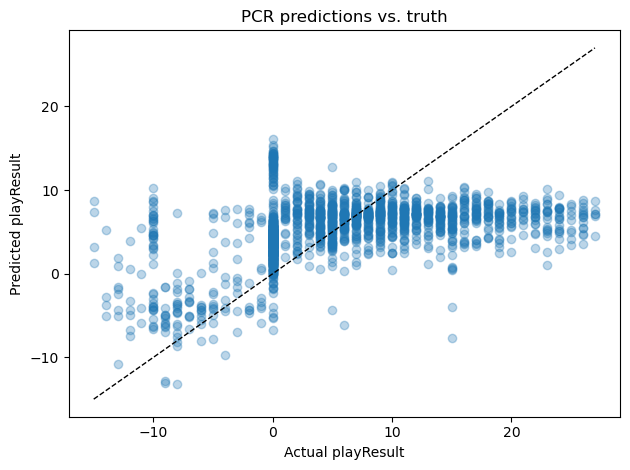

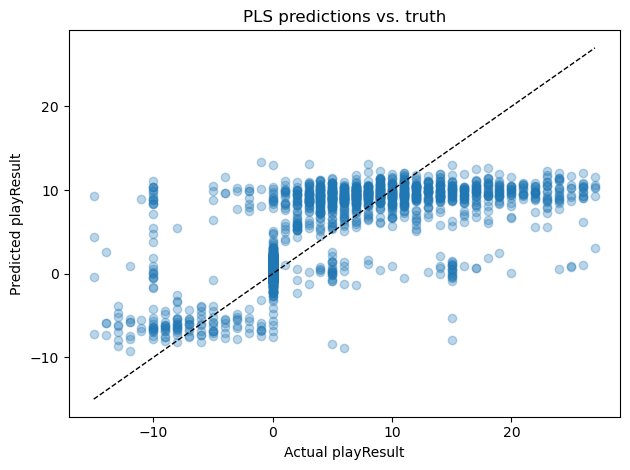

In [28]:
import matplotlib.pyplot as plt

for name, model in [("PCR", pcr_final), ("PLS", pls_final)]:
    y_pred = model.predict(X_test)
    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'k--', lw=1)
    plt.xlabel("Actual playResult")
    plt.ylabel("Predicted playResult")
    plt.title(f"{name} predictions vs. truth")
    plt.tight_layout()
plt.show()

The test‐set results reinforce what we saw on CV:
- PCR (20 PCA comps + Ridge $\alpha=10$): $R^2_{test} \approx 0.206$ 
- PLS (10 components):  $R^2_{test} \approx 0.457$ 

PLS clearly outperforms PCR here. Because PLS finds components that maximize covariance with the target, it captures more of the signal in fewer dimensions.

Absolute $R^2$ is still modest, explaining ≈ 45% of variance means there’s a lot of unexplained structure—perhaps non-linear effects, important interactions, or simply noisy outcomes.